# Gradient Project | File Preparation Code  
## This code takes in the raw files and outputs gradient and trend calculations

Ensure that we are using all unique models  
Calculate the std jump in this file

Other potential updates:  
* Make some of the variables universal so that you only have to set them once (e.g., start time and end time)  
* Check that the scenario models span the full time that we need

In [1]:
%reset -f

In [2]:
%load_ext autoreload

In [3]:
%reload_ext autoreload
%autoreload 2

In [63]:
# initialising the environment

# analysis functions
import numpy as np
import xarray as xr
from math import exp, pi, sin, sqrt, log, radians, isnan
from scipy.stats import linregress
import cftime
import pandas as pd
import nc_time_axis
import random

# systems functions
import sys
from collections import defaultdict
import os
import json

# plotting functions
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# my own functions
from modelchecks_hb import lat_lon_res_Eq
from GradTrendClasses import ModelInput, Gradient, Trend, TrendPlotting
from GradientProjectFunctions import ClassifyModels, ConcatModels, ExtendPeriod, CreateScenarioDictionary, RemoveClimatology, CropTrendsDf

## Running this for several urls

In [14]:
# inputting from a csv file
directory = '/home/hbyrne/Research/Gradient_project/OpenDap_inputs'

# inputting the historical data
fileName = 'cmip6_historical_opendap.csv'
os.chdir(directory)
inputHist = pd.read_csv(fileName)

# inputting the scenario data
fileName = 'cmip6_ScenarioMIP_opendap.csv'
inputScenario = pd.read_csv(fileName)

# filtering for the subset of links we are interested in
# first filtering the Scenario datasets because these are more limited
scenarioFilt = inputScenario[(inputScenario['experiment_id'] == 'ssp245') &
                             (inputScenario['variable_id'] == 'ts') &
                             (inputScenario['grid_label'] == 'gn')
                            ]

# filtering the historical datasets based on which also have scenarios
histFilt = inputHist[inputHist['source_id'].isin(scenarioFilt['source_id']) &
                     (inputHist['variable_id'] == 'ts') & 
                     (inputHist['grid_label'] == 'gn') &
                     (inputHist['source_id'].isin(['MIROC6'])) # this line is just to make it a reasonable number of models
                    ]

# then refiltering the filtered scenario list based on the historical list in case there were some scenario ones that don't have historical runs (unlikely)
scenarioFilt = scenarioFilt[scenarioFilt['source_id'].isin(histFilt['source_id'])]

# saving all of the urls into one list
modelListHist = histFilt['URL'].tolist()
modelListScenario = scenarioFilt['URL'].tolist()

In [16]:
# Creating shorter lists until we have been able to parallelise

# three MIROC6 runs (r10, 11, 12)
modelListHist = ['http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/MIROC/MIROC6/historical/r10i1p1f1/Amon/ts/gn/v20181212/ts_Amon_MIROC6_historical_r10i1p1f1_gn_185001-194912.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/MIROC/MIROC6/historical/r10i1p1f1/Amon/ts/gn/v20181212/ts_Amon_MIROC6_historical_r10i1p1f1_gn_195001-201412.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/MIROC/MIROC6/historical/r11i1p1f1/Amon/ts/gn/v20200519/ts_Amon_MIROC6_historical_r11i1p1f1_gn_185001-194912.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/MIROC/MIROC6/historical/r11i1p1f1/Amon/ts/gn/v20200519/ts_Amon_MIROC6_historical_r11i1p1f1_gn_195001-201412.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/MIROC/MIROC6/historical/r12i1p1f1/Amon/ts/gn/v20200519/ts_Amon_MIROC6_historical_r12i1p1f1_gn_185001-194912.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/MIROC/MIROC6/historical/r12i1p1f1/Amon/ts/gn/v20200519/ts_Amon_MIROC6_historical_r12i1p1f1_gn_195001-201412.nc']

In [17]:
# shorter version of the model list for scenarios (Note that this has all required MIROC runs and some others)

modelListScenario = ['http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r10i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r10i1p1f1_gn_201501-203912.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r11i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r11i1p1f1_gn_201501-203912.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r12i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r12i1p1f1_gn_201501-203912.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r13i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r13i1p1f1_gn_201501-203912.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r14i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r14i1p1f1_gn_201501-203912.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r1i1p1f1/Amon/ts/gn/v20190815/ts_Amon_CESM2-WACCM_ssp245_r1i1p1f1_gn_201501-206412.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r1i1p1f1/Amon/ts/gn/v20190815/ts_Amon_CESM2-WACCM_ssp245_r1i1p1f1_gn_206501-210012.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r2i1p1f1/Amon/ts/gn/v20200224/ts_Amon_CESM2-WACCM_ssp245_r2i1p1f1_gn_201501-206412.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r2i1p1f1/Amon/ts/gn/v20200224/ts_Amon_CESM2-WACCM_ssp245_r2i1p1f1_gn_206501-210012.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r3i1p1f1/Amon/ts/gn/v20200206/ts_Amon_CESM2-WACCM_ssp245_r3i1p1f1_gn_201501-206412.nc']

In [21]:
classifiedModels = ClassifyModels(modelListHist)

/home/hbyrne/miniconda3/envs/hb_1129/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
libtbb.so.2: cannot open shared object file: No such file or directory
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [22]:
classifiedModels.keys()

dict_keys(['MIROC6_r10i1p1f1', 'MIROC6_r11i1p1f1', 'MIROC6_r12i1p1f1', 'MIROC6_r13i1p1f1', 'MIROC6_r14i1p1f1', 'MIROC6_r15i1p1f1', 'MIROC6_r16i1p1f1', 'MIROC6_r17i1p1f1', 'MIROC6_r18i1p1f1', 'MIROC6_r19i1p1f1', 'MIROC6_r1i1p1f1', 'MIROC6_r20i1p1f1', 'MIROC6_r21i1p1f1', 'MIROC6_r22i1p1f1', 'MIROC6_r23i1p1f1', 'MIROC6_r24i1p1f1', 'MIROC6_r25i1p1f1', 'MIROC6_r26i1p1f1', 'MIROC6_r27i1p1f1', 'MIROC6_r28i1p1f1', 'MIROC6_r29i1p1f1', 'MIROC6_r2i1p1f1', 'MIROC6_r30i1p1f1', 'MIROC6_r31i1p1f1', 'MIROC6_r32i1p1f1', 'MIROC6_r33i1p1f1', 'MIROC6_r34i1p1f1', 'MIROC6_r35i1p1f1', 'MIROC6_r36i1p1f1', 'MIROC6_r37i1p1f1', 'MIROC6_r38i1p1f1', 'MIROC6_r39i1p1f1', 'MIROC6_r3i1p1f1', 'MIROC6_r40i1p1f1', 'MIROC6_r41i1p1f1', 'MIROC6_r42i1p1f1', 'MIROC6_r43i1p1f1', 'MIROC6_r44i1p1f1', 'MIROC6_r45i1p1f1', 'MIROC6_r46i1p1f1', 'MIROC6_r47i1p1f1', 'MIROC6_r48i1p1f1', 'MIROC6_r49i1p1f1', 'MIROC6_r4i1p1f1', 'MIROC6_r50i1p1f1', 'MIROC6_r5i1p1f1', 'MIROC6_r6i1p1f1', 'MIROC6_r7i1p1f1', 'MIROC6_r8i1p1f1', 'MIROC6_r9i1p1f1'

In [23]:
scenarioModels = CreateScenarioDictionary(modelListScenario)

In [55]:
# creating a dictionary to store all of the trends information and attributes:
trendsDict = {}
trendsDfDict = {}
gradDict = {}
counter = 0
modelCount = len(classifiedModels.keys())

for key in classifiedModels:
    
    if key == 'Full':
        for model in classifiedModels[key]:
            # loading and checking the data
            modelInput = ModelInput(model)
            
            # extending the model period through adding in scenarios
            modelFullPeriod = ExtendPeriod(key, modelInput, scenarioModels)
            
            # remove the climatology from the full dataset
            modelFullPeriod = RemoveClimatology(modelFullPeriod)

            # calculating the gradient and the trends; creating dict with all trends labelled with model name
            gradient = Gradient(modelFullPeriod)
            gradDict[gradient.modelName] = gradient.gradient
            trendsDict[gradient.modelName] = Trend(gradient).trends
            trendsDfDict[gradient.modelName] = Trend(gradient).trendsDf
    
    else:
        # concatenating to the length of the initial period
        model = ConcatModels(classifiedModels[key])
        
        # loading and checking the data
        modelInput = ModelInput(model)
        
        # extending the model period through adding in scenarios
        modelFullPeriod = ExtendPeriod(key, modelInput, scenarioModels)
        
        # remove the climatology from the full dataset
        modelFullPeriod = RemoveClimatology(modelFullPeriod)
        
        # calculating the gradient and the trends; creating dict with all trends labelled with model name
        gradient = Gradient(modelFullPeriod)
        gradDict[gradient.modelName] = gradient.gradient
        trendsDict[gradient.modelName] = Trend(gradient).trends
        trendsDfDict[gradient.modelName] = Trend(gradient).trendsDf
    
    counter+=1
    print(f'{counter} / {modelCount}')

Non-random - Hist: MIROC6_r10i1p1f1 and Scenario: http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r10i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r10i1p1f1_gn_201501-203912.nc
1 / 50
Non-random - Hist: MIROC6_r11i1p1f1 and Scenario: http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r11i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r11i1p1f1_gn_201501-203912.nc
2 / 50
Non-random - Hist: MIROC6_r12i1p1f1 and Scenario: http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r12i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r12i1p1f1_gn_201501-203912.nc
3 / 50
Non-random - Hist: MIROC6_r13i1p1f1 and Scenario: http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r13i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r13i1p1f1_gn_201501-203912.nc
4 / 50
Non-random - Hist: MIROC6_r14i1p1f1 and Scenario: http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC

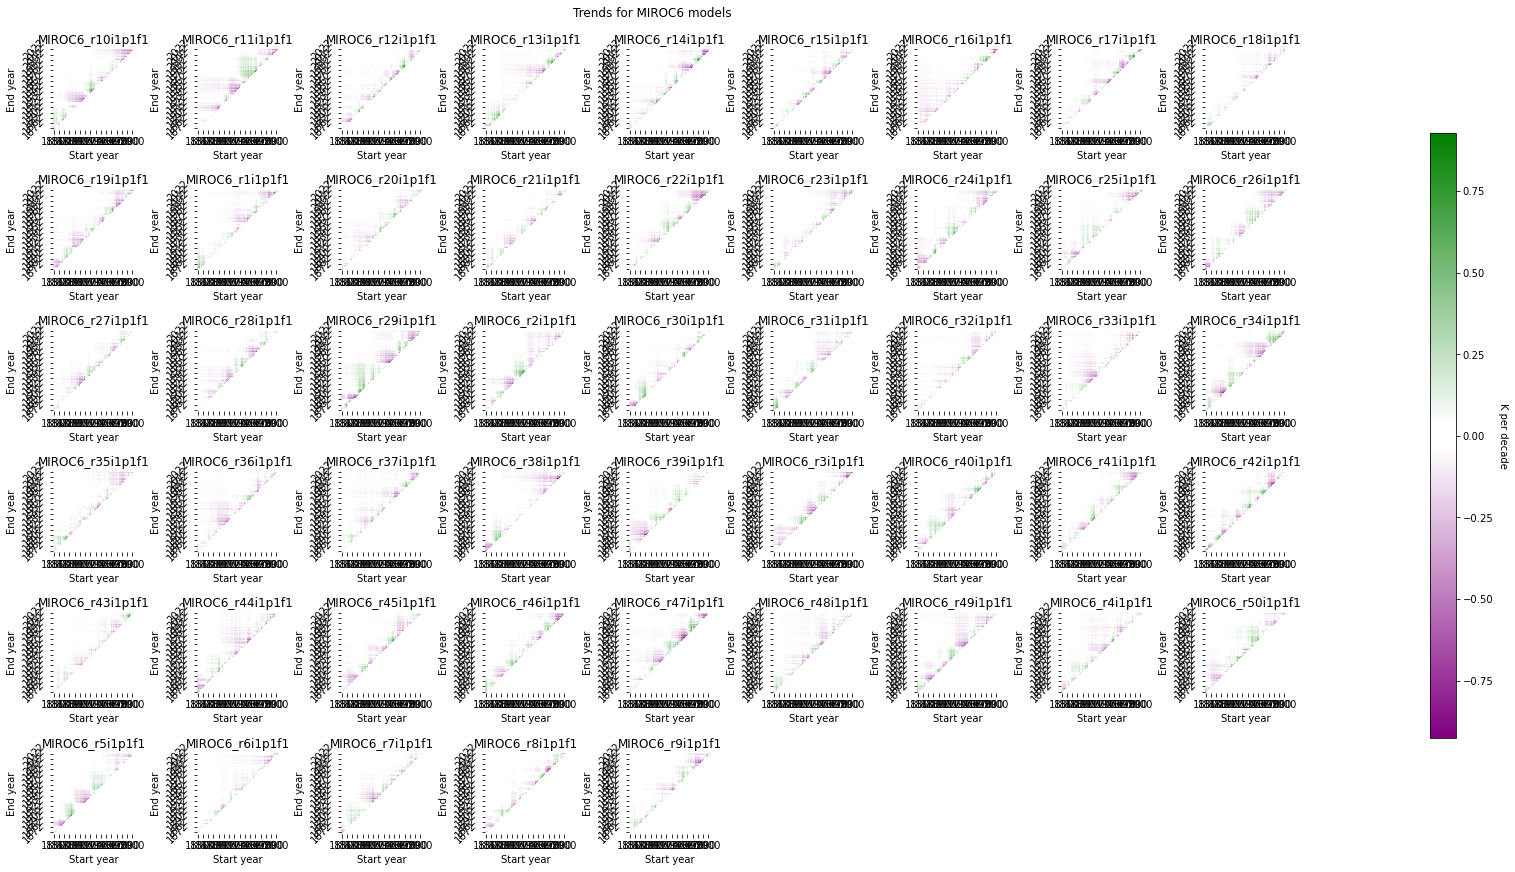

In [64]:
plotsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Plots'

nModels = len(trendsDict)

nCols = 9
if nModels % nCols == 0:
    nRows = int(nModels/nCols)
else:
    nRows = int(np.floor(nModels/nCols) + 1)

subplotSize = (2, 2)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]

fig = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig.suptitle('Trends for MIROC6 models')
subplot = 0

axesList = []

# colormap

# calculating max and min values to set the limits for the heatmaps
vmin = min(value for innerDict in trendsDict.values() for value in innerDict.values() if not np.isnan(value))
vmax = max(value for innerDict in trendsDict.values() for value in innerDict.values() if not np.isnan(value))

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit

# setting the colorbar
colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)
    
for modelName, trends in trendsDfDict.items():
    # cropping the trends Df so that plotting doesn't include deadspace
    offset = 20 # years
    trendsDfCrop = CropTrendsDf(trends, offset)
    
    subplot += 1
    ax = fig.add_subplot(nRows, nCols, subplot)
    ax.set_aspect('equal')
    trendPlotter = TrendPlotting(trendsDfCrop, modelName, vmin, vmax, cmap, norm)
    ax = trendPlotter.PlotTrends(ax)  
    axesList.append(ax)

cbarAx = fig.add_axes([1.1, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('K per decade', rotation = 270, labelpad = 15)

os.chdir(plotsDir)
plt.savefig('MIROC_triangles.png')
plt.show()

## Saving files to output

In [71]:
trendsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Trends'
gradientsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients'

# saving the trends
# note that this will be saving the dataframes with the trends saved in them
os.chdir(trendsDir)

for modelName, trends in trendsDfDict.items():
    fileName = modelName+'_trends.csv'
    trends.to_csv(fileName, index = True)
    
# saving the gradients

for modelName, gradients in gradDict.items():
    pathName = gradientsDir+'/'+modelName+'.nc'
    gradients.to_netcdf(pathName)

In [73]:
trendsDfDict['MIROC6_r10i1p1f1']

start_year,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
end_year,,,,,,,,,,,,,,,,,,,,,
2022,-0.016636,-0.016818,-0.020491,-0.023465,-0.023505,-0.023821,-0.023817,-0.025783,-0.031088,-0.031940,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021,-0.016271,-0.016451,-0.020163,-0.023169,-0.023205,-0.023522,-0.023514,-0.025500,-0.030867,-0.031727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020,-0.017964,-0.018166,-0.021943,-0.025006,-0.025065,-0.025409,-0.025423,-0.027457,-0.032915,-0.033810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019,-0.015679,-0.015856,-0.019651,-0.022723,-0.022755,-0.023075,-0.023061,-0.025091,-0.030587,-0.031465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018,-0.011458,-0.011587,-0.015376,-0.018434,-0.018414,-0.018684,-0.018616,-0.020616,-0.026125,-0.026957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
